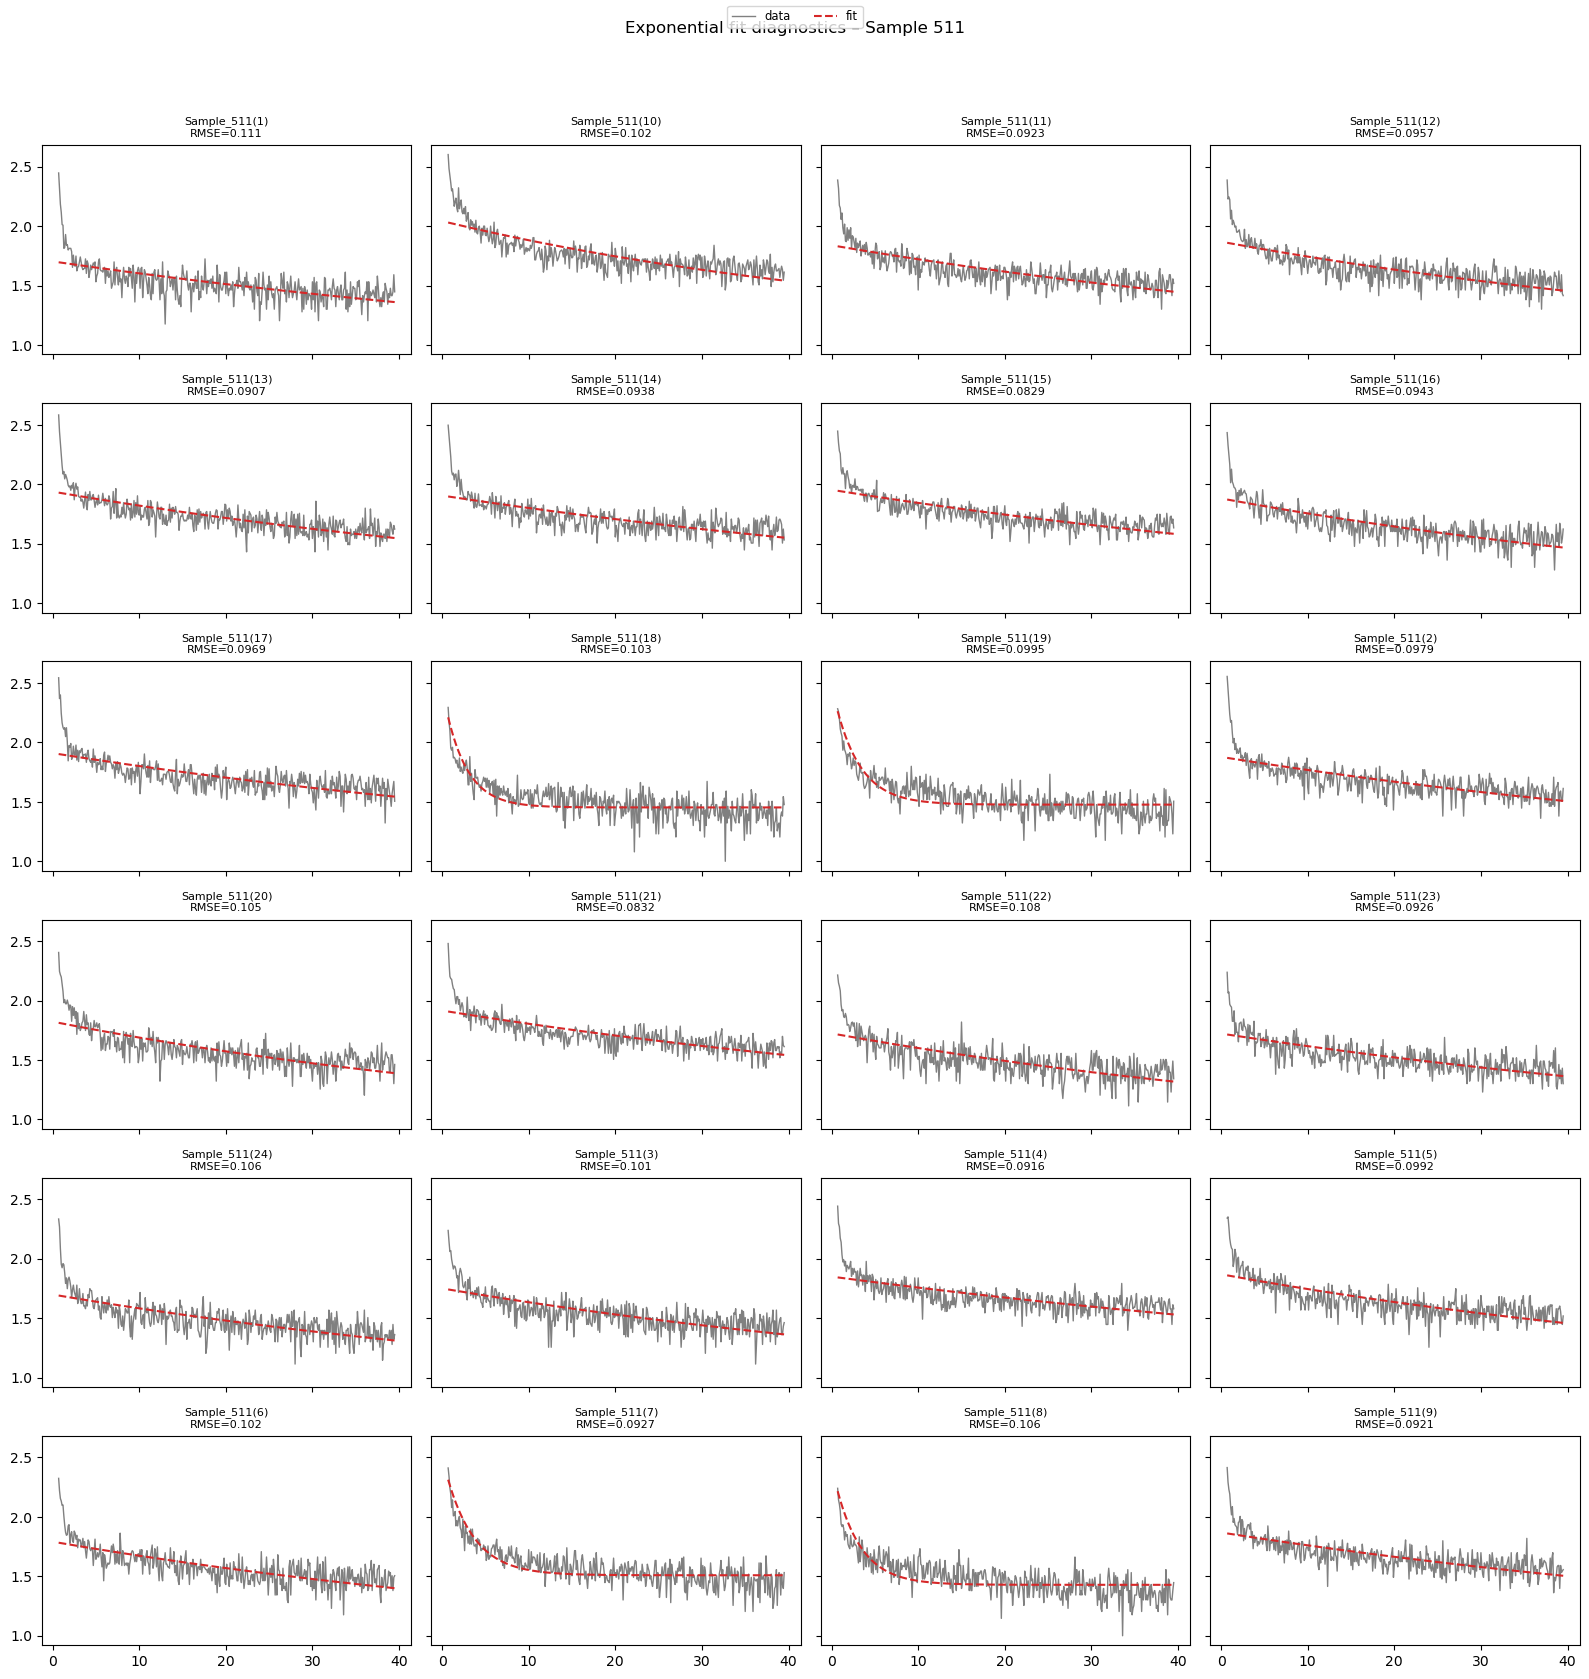

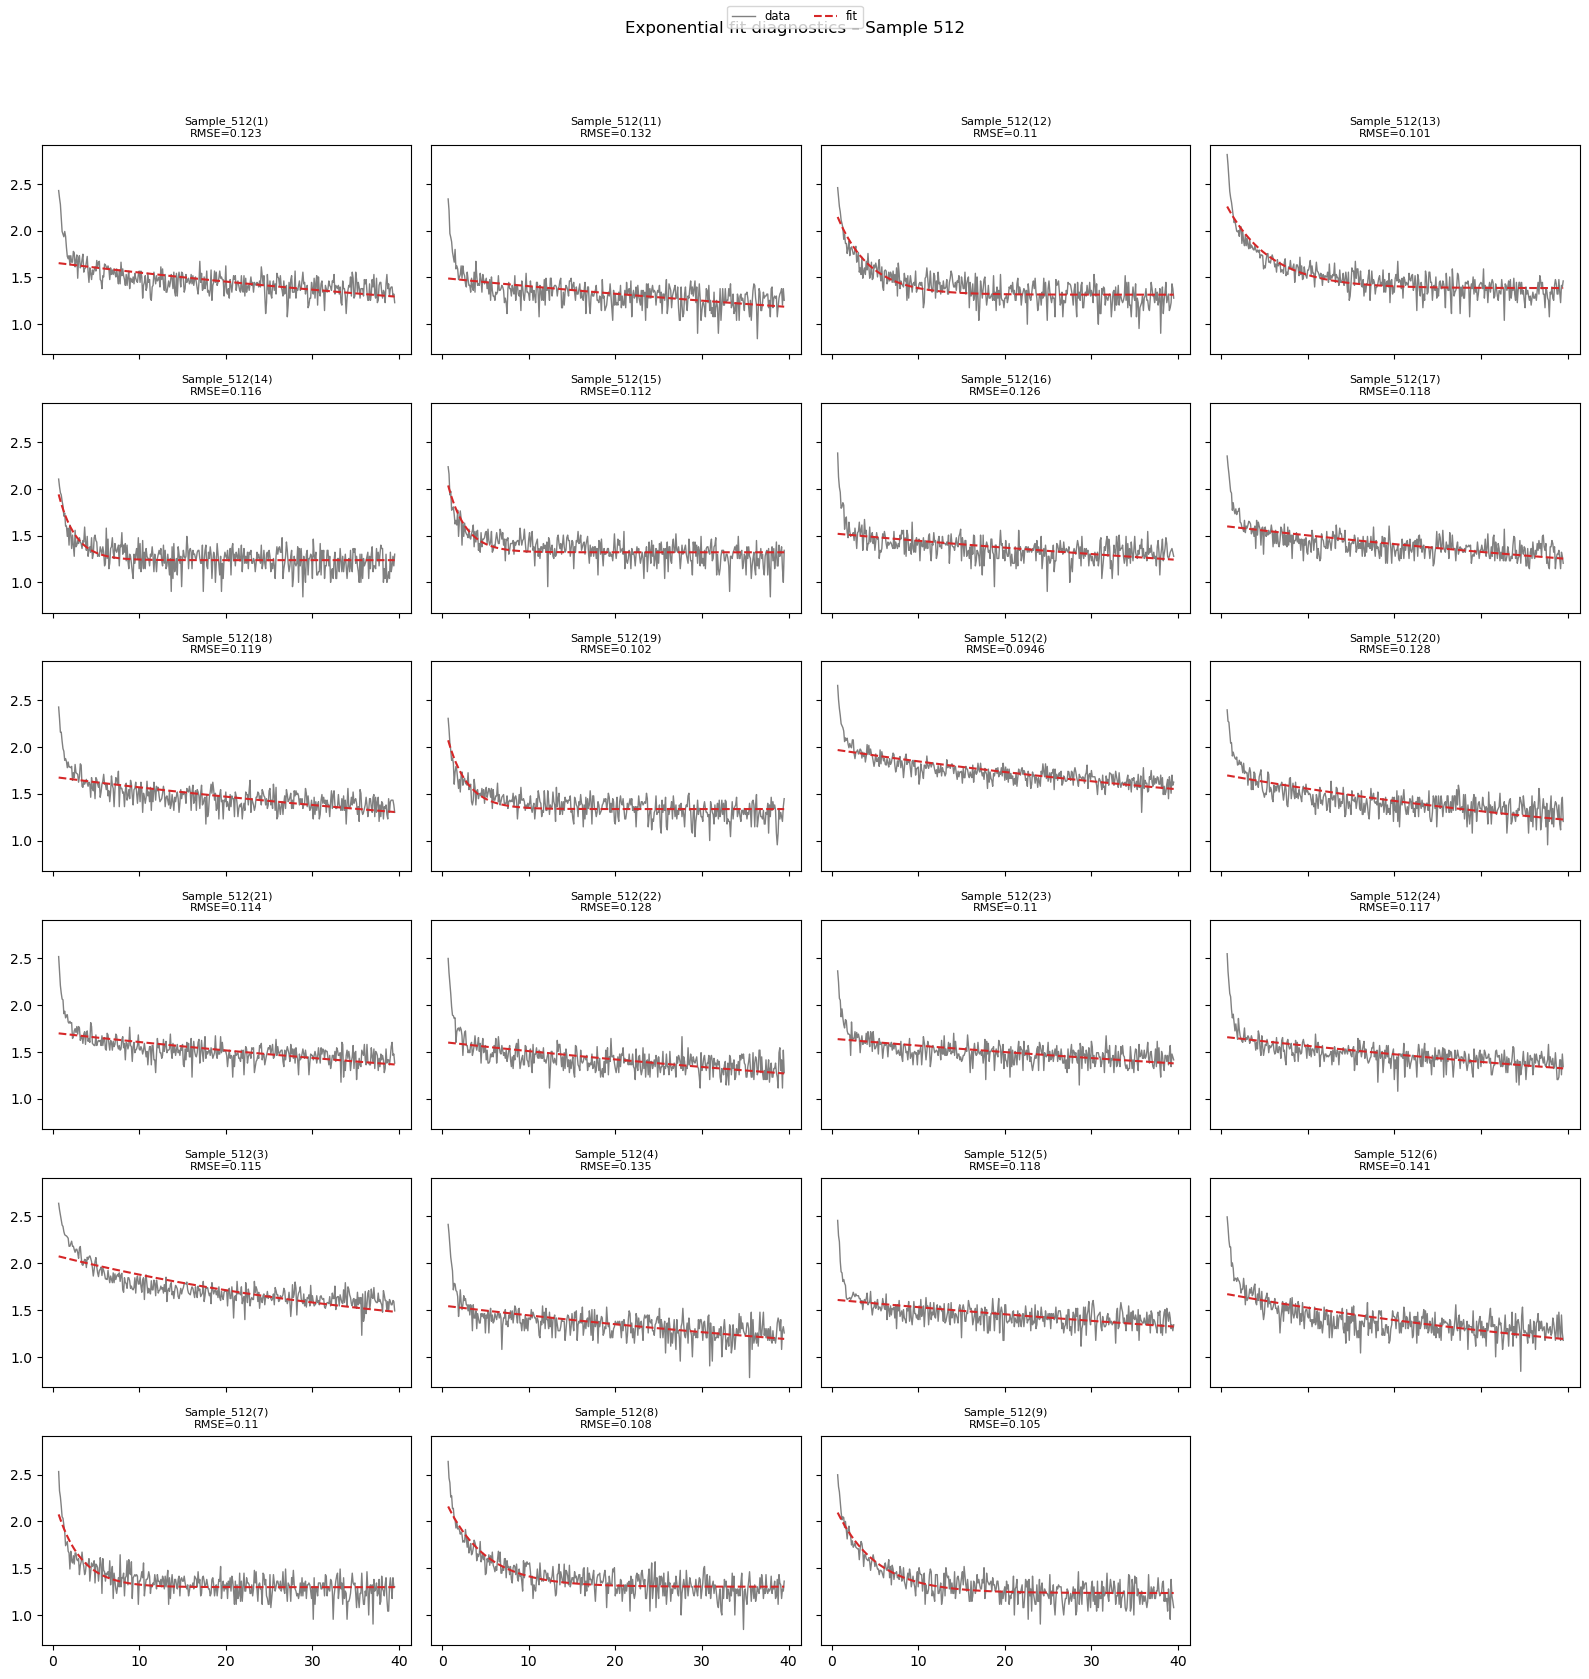

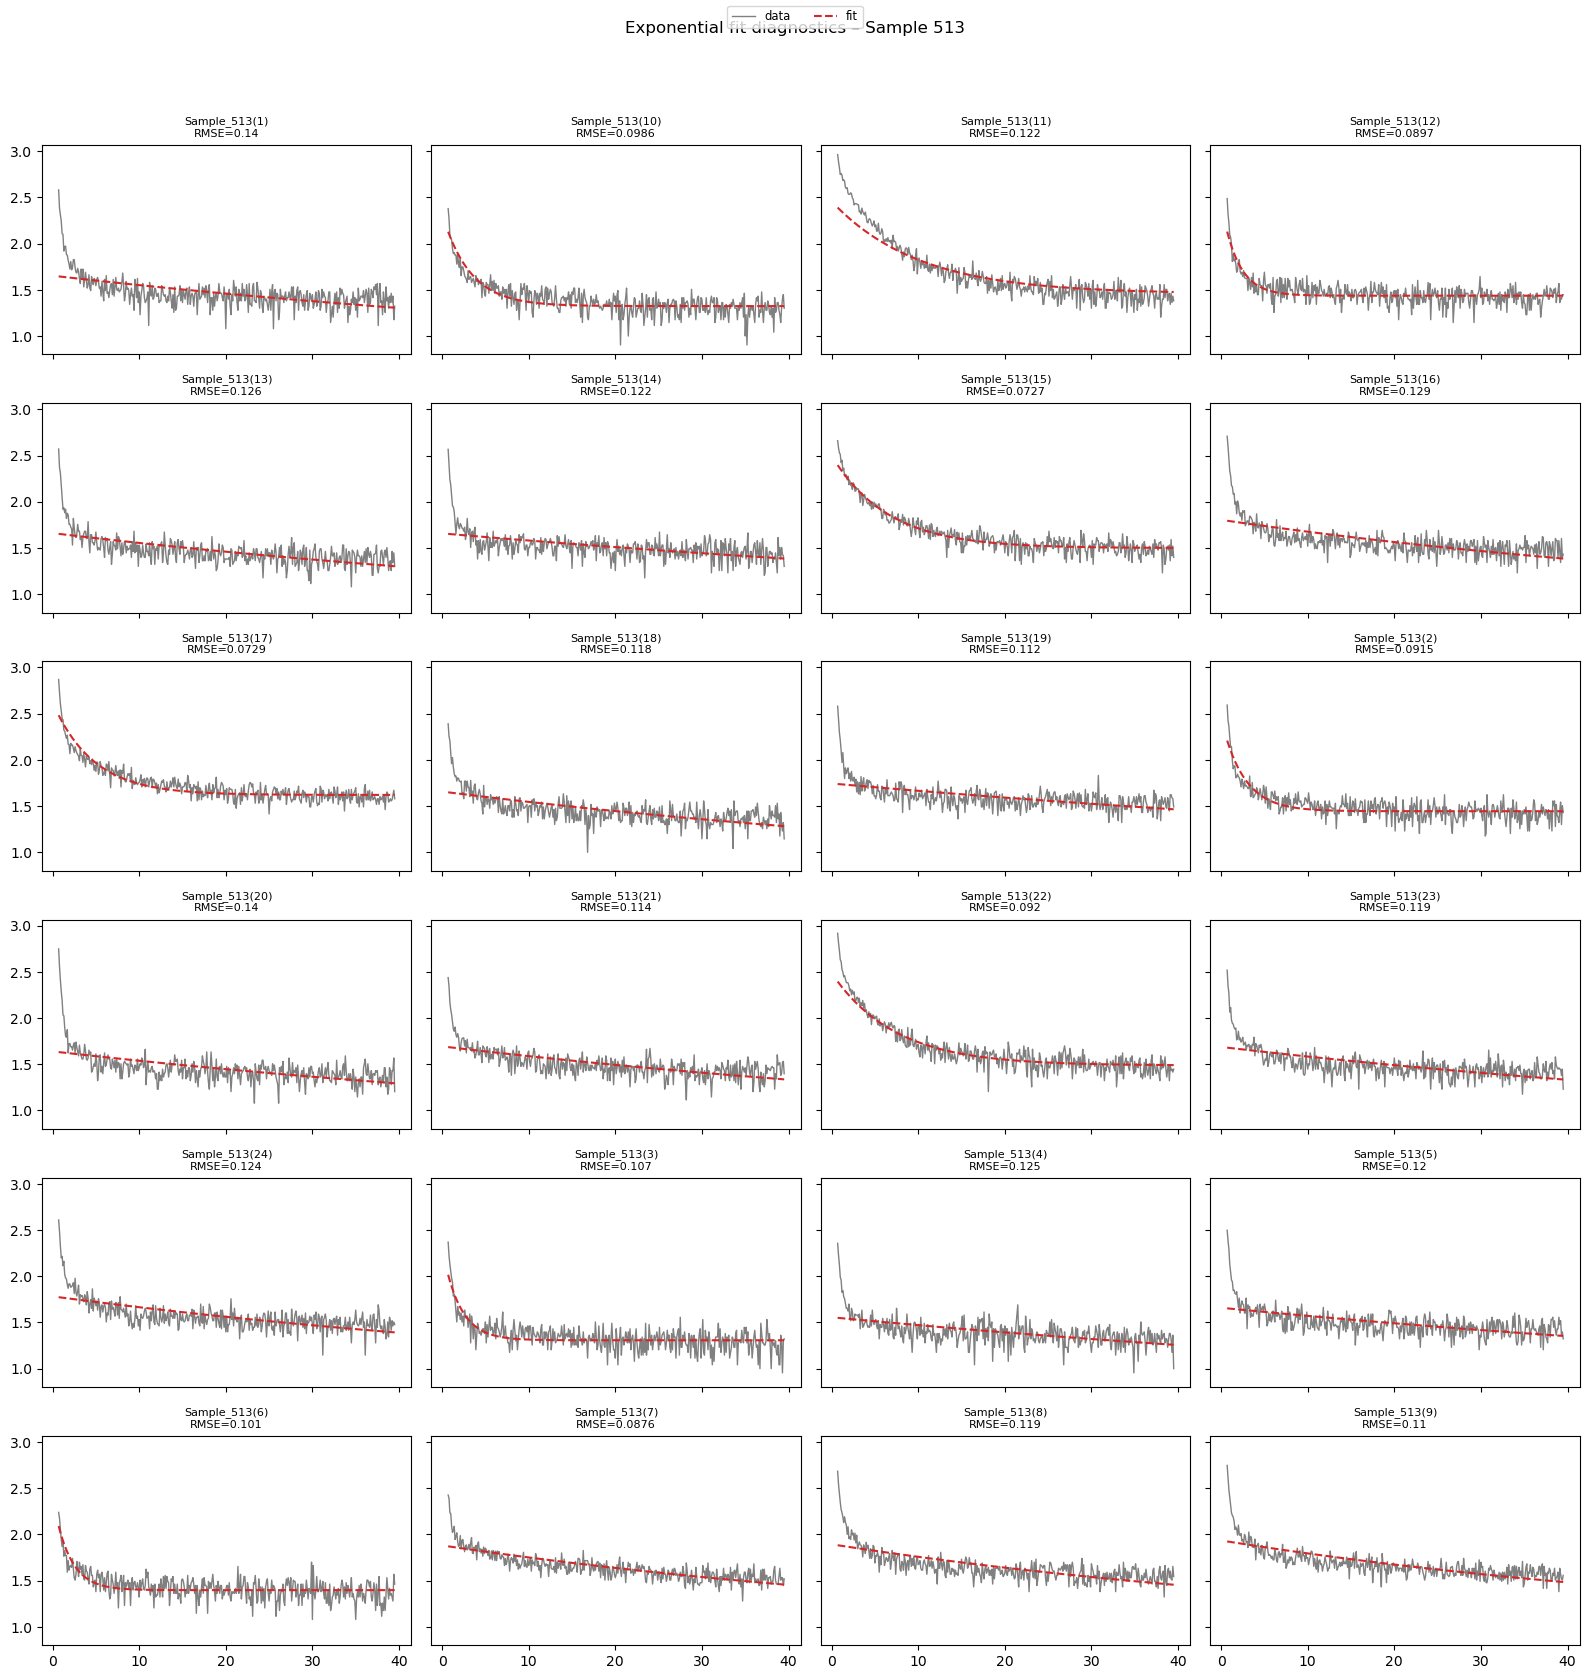

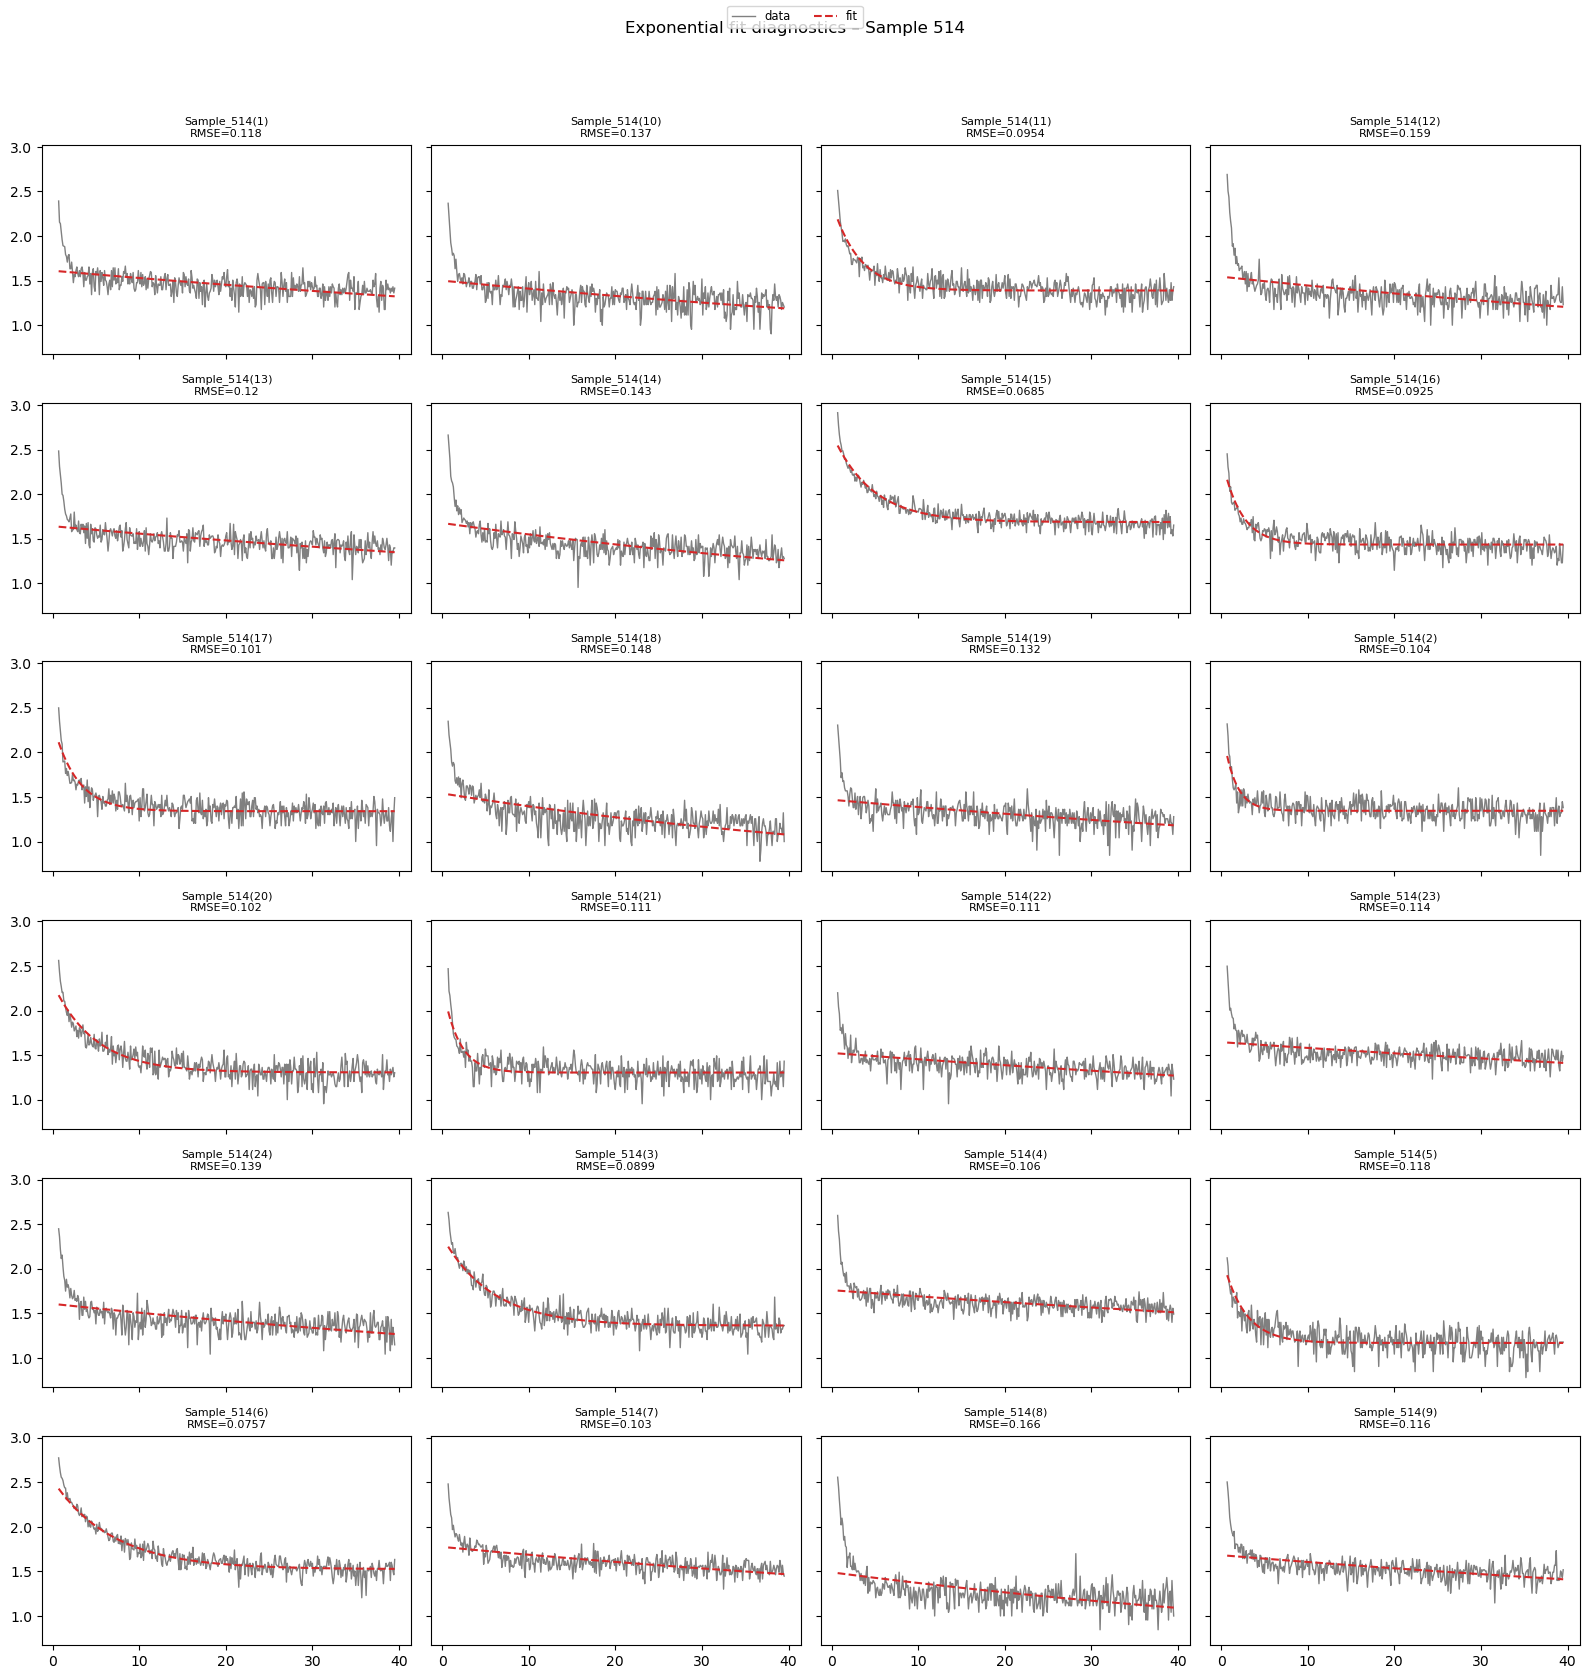

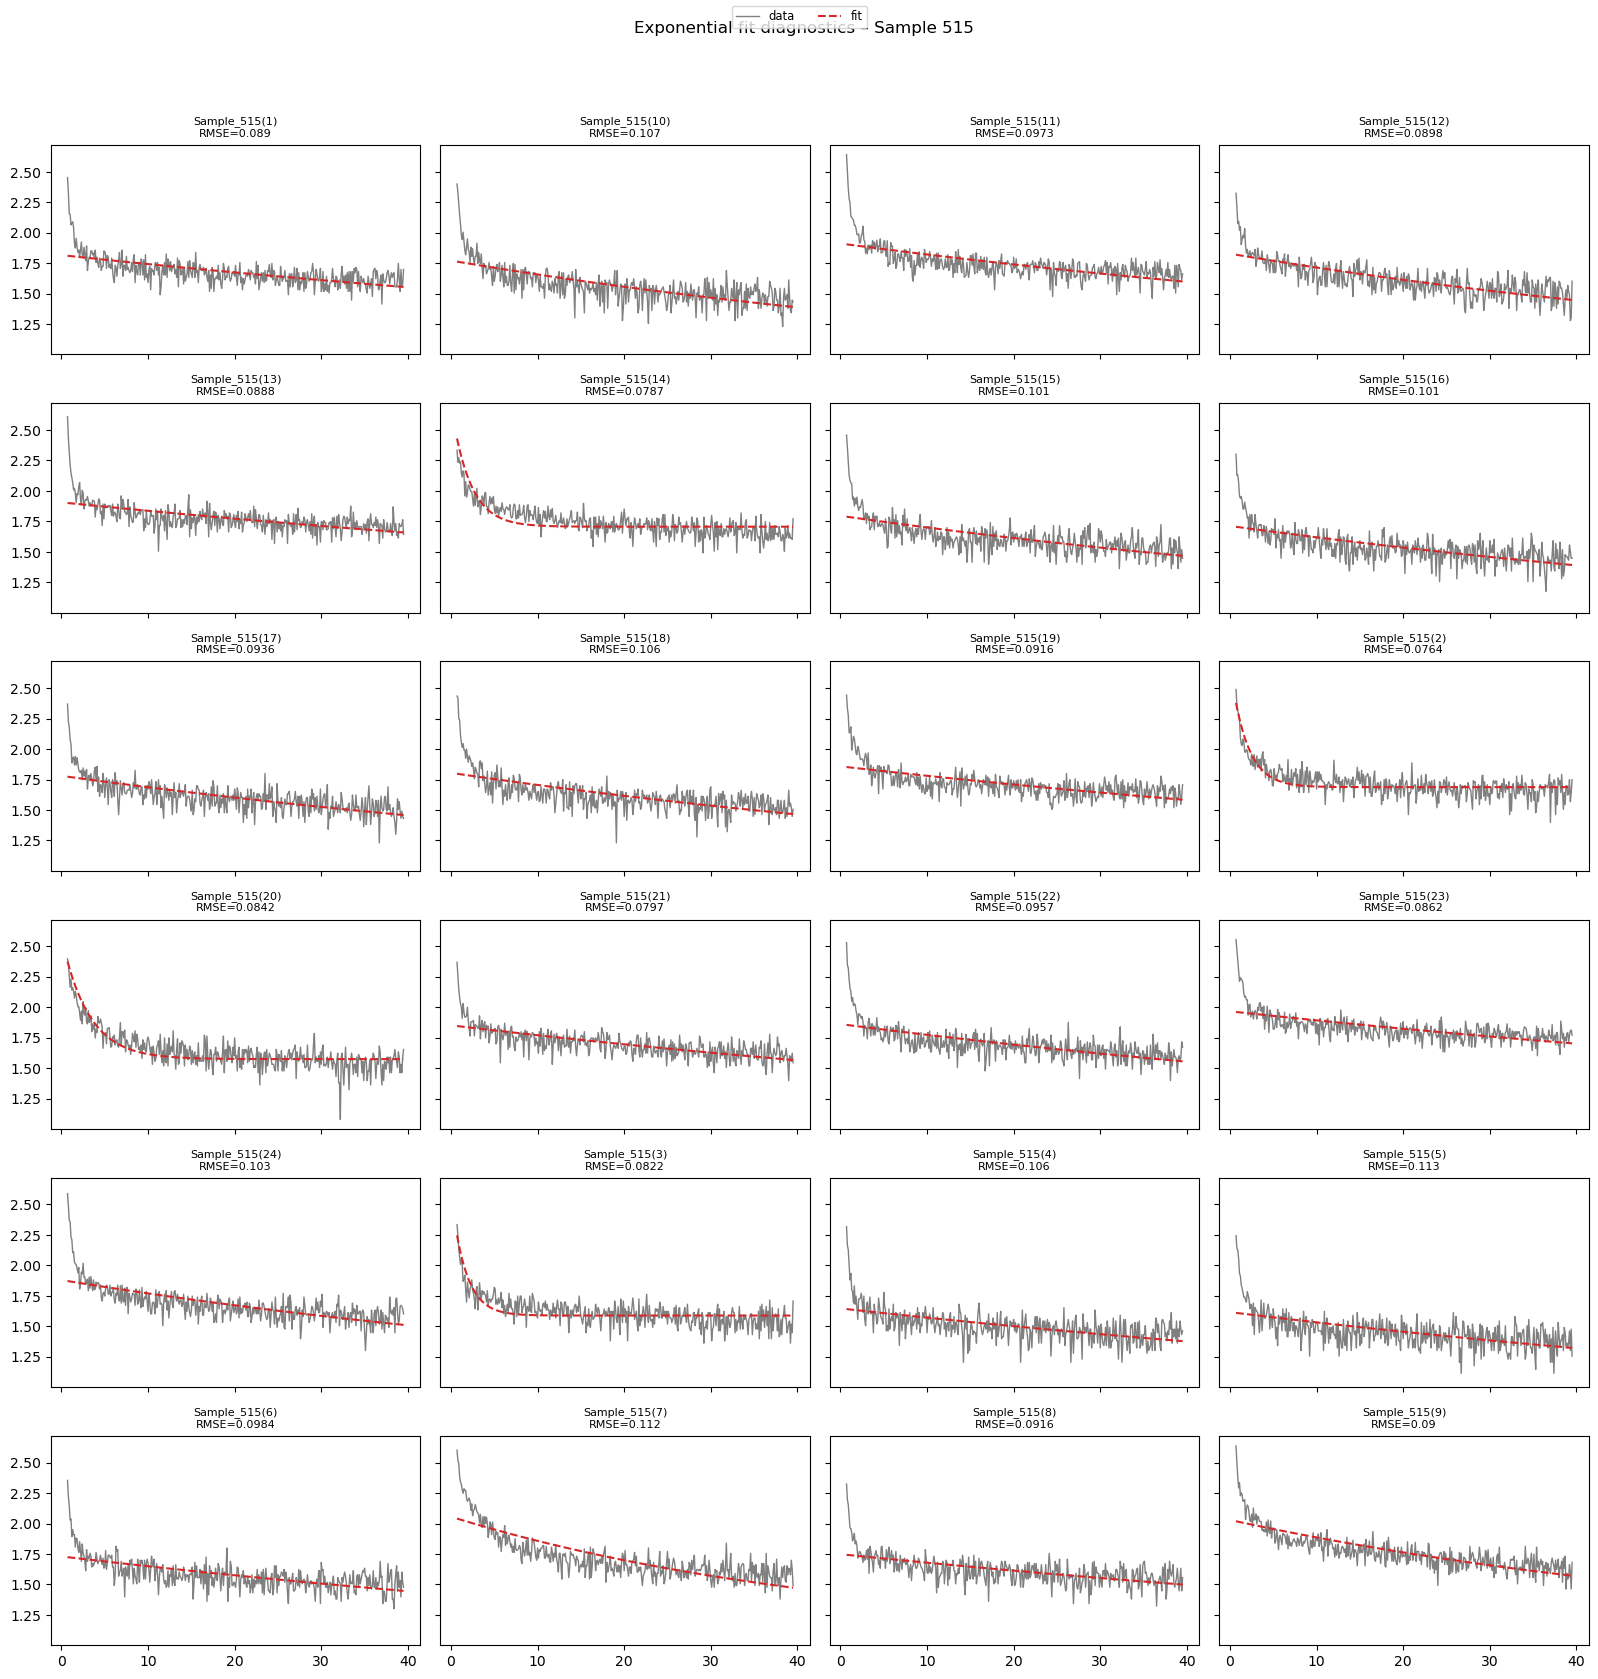

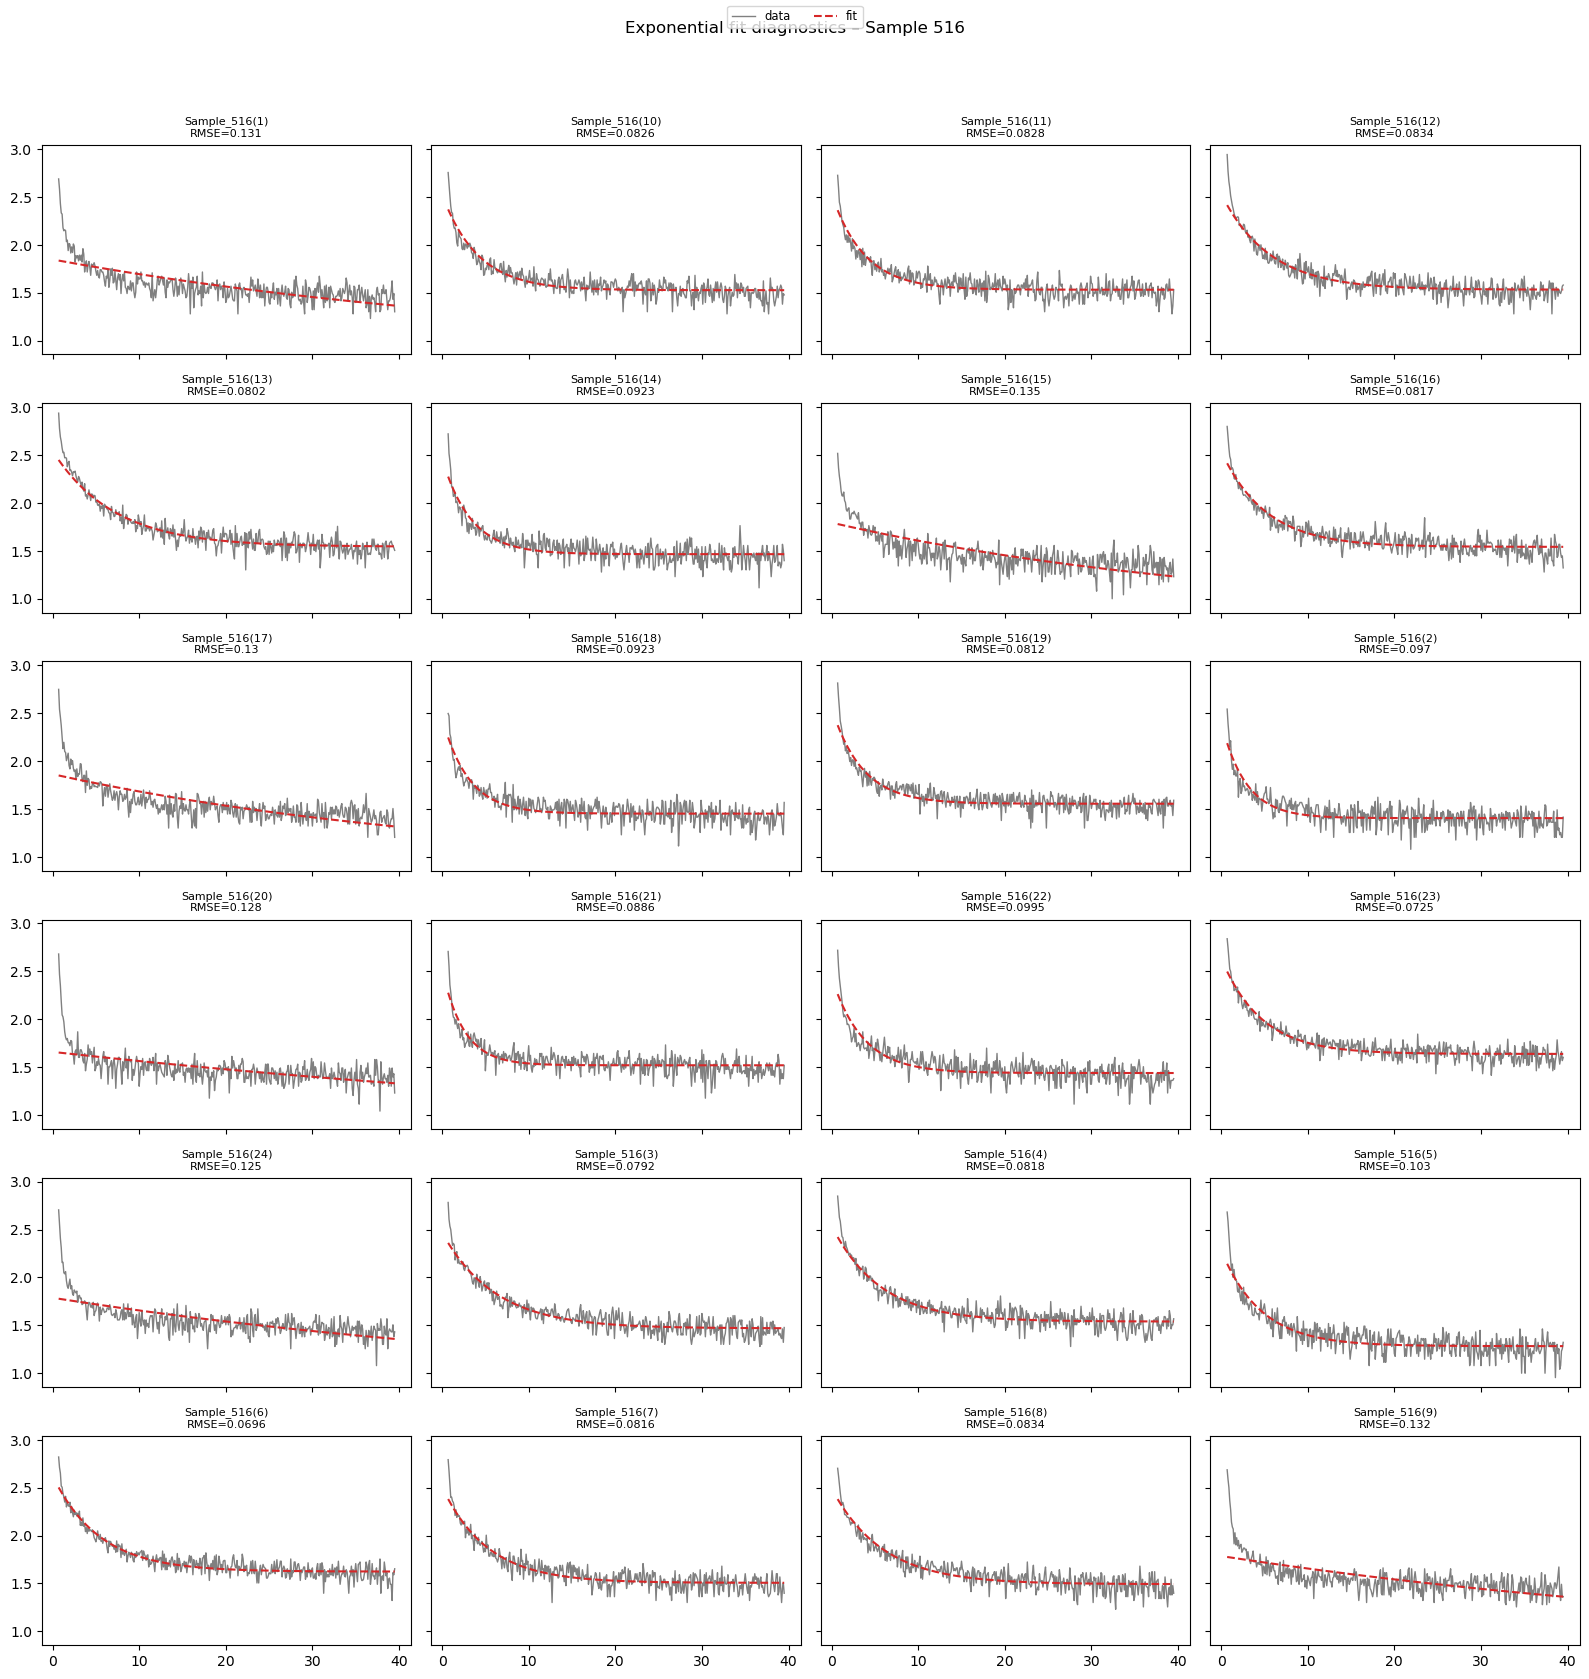

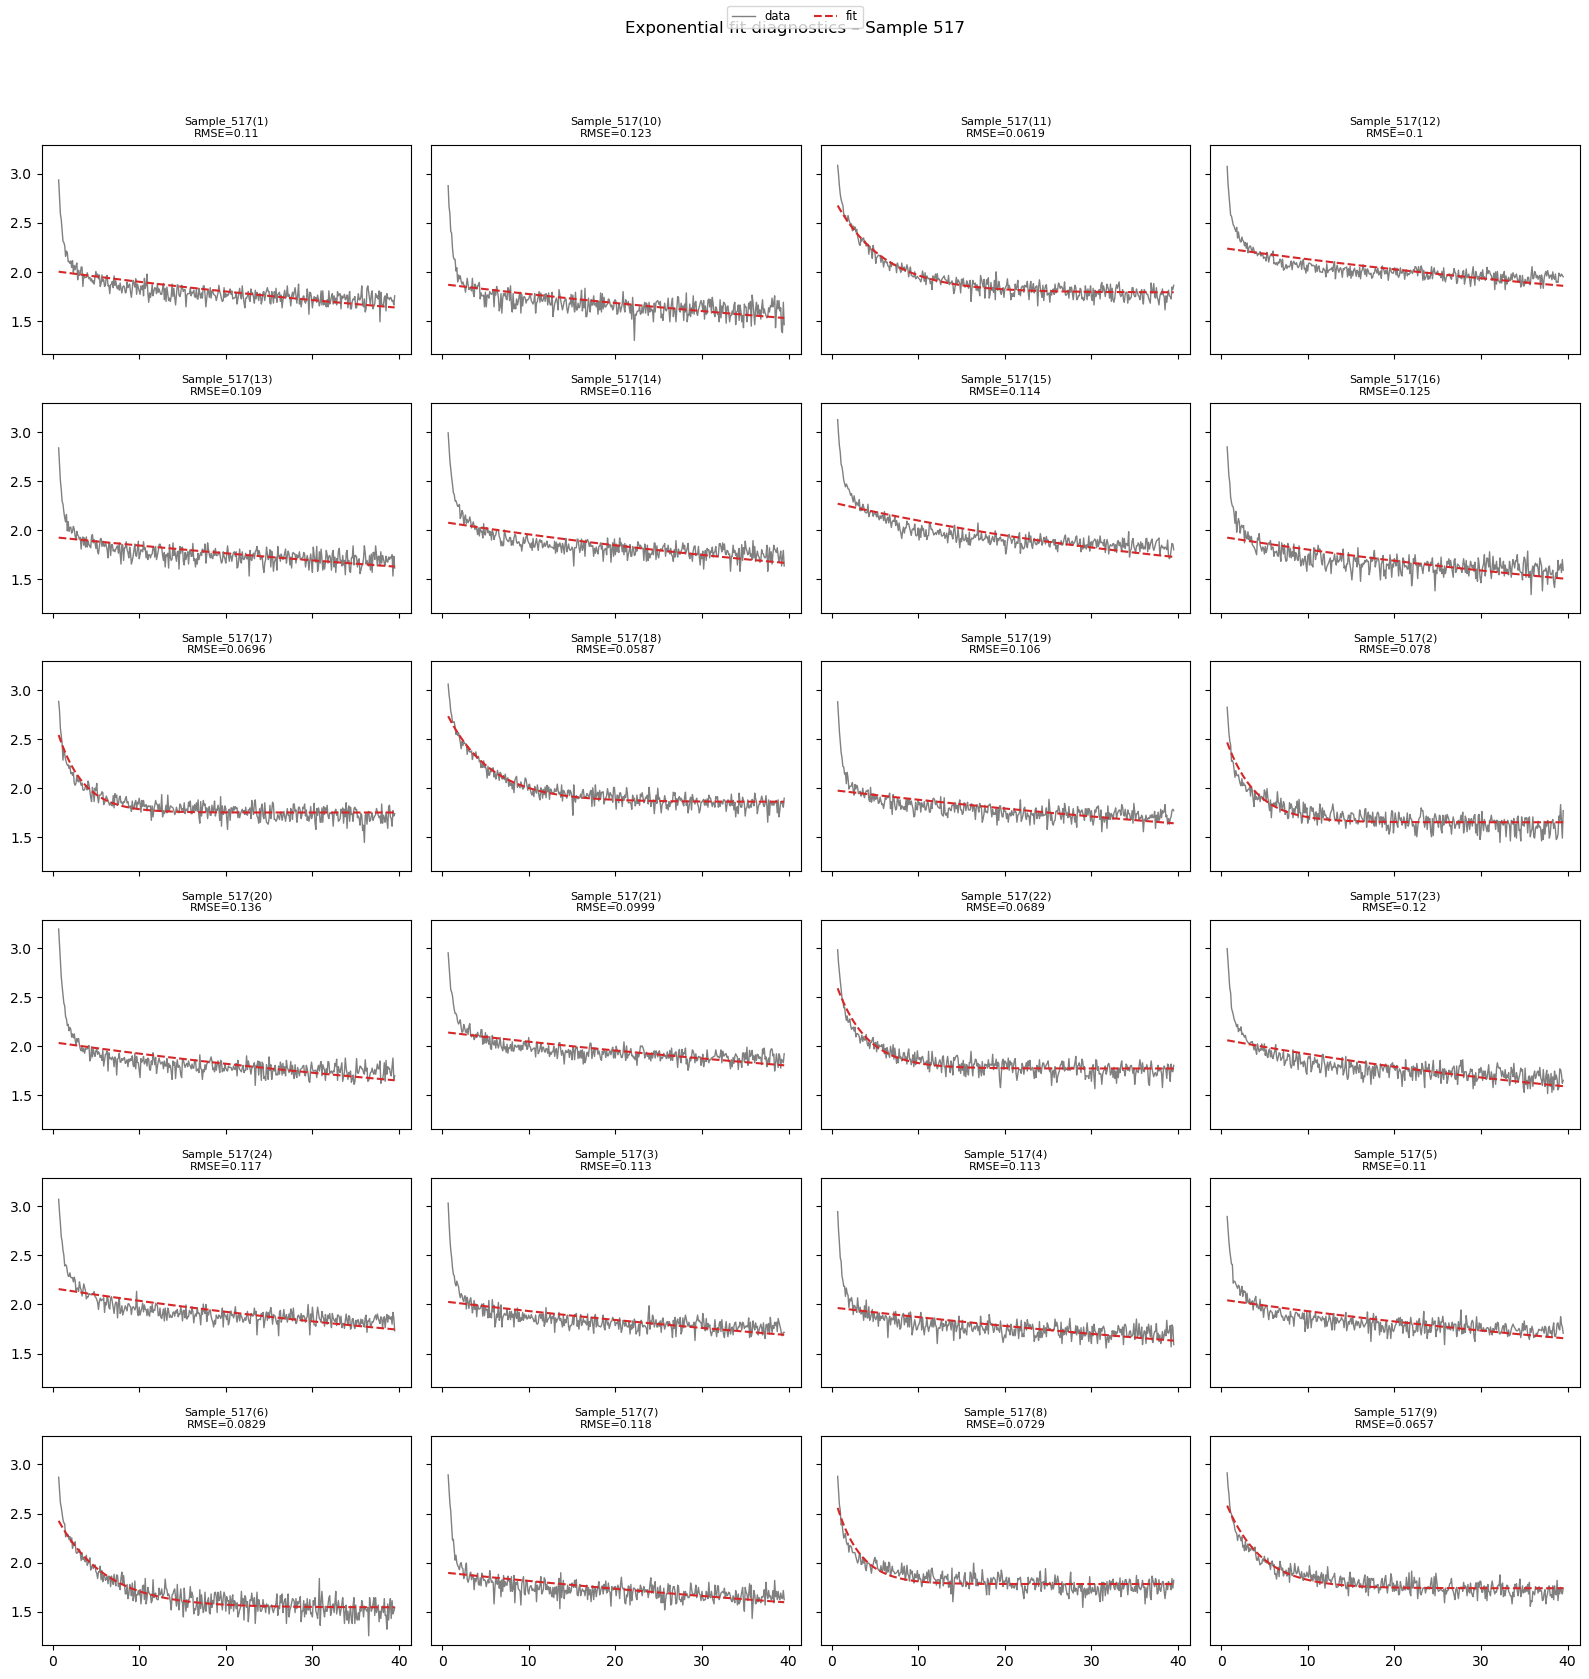

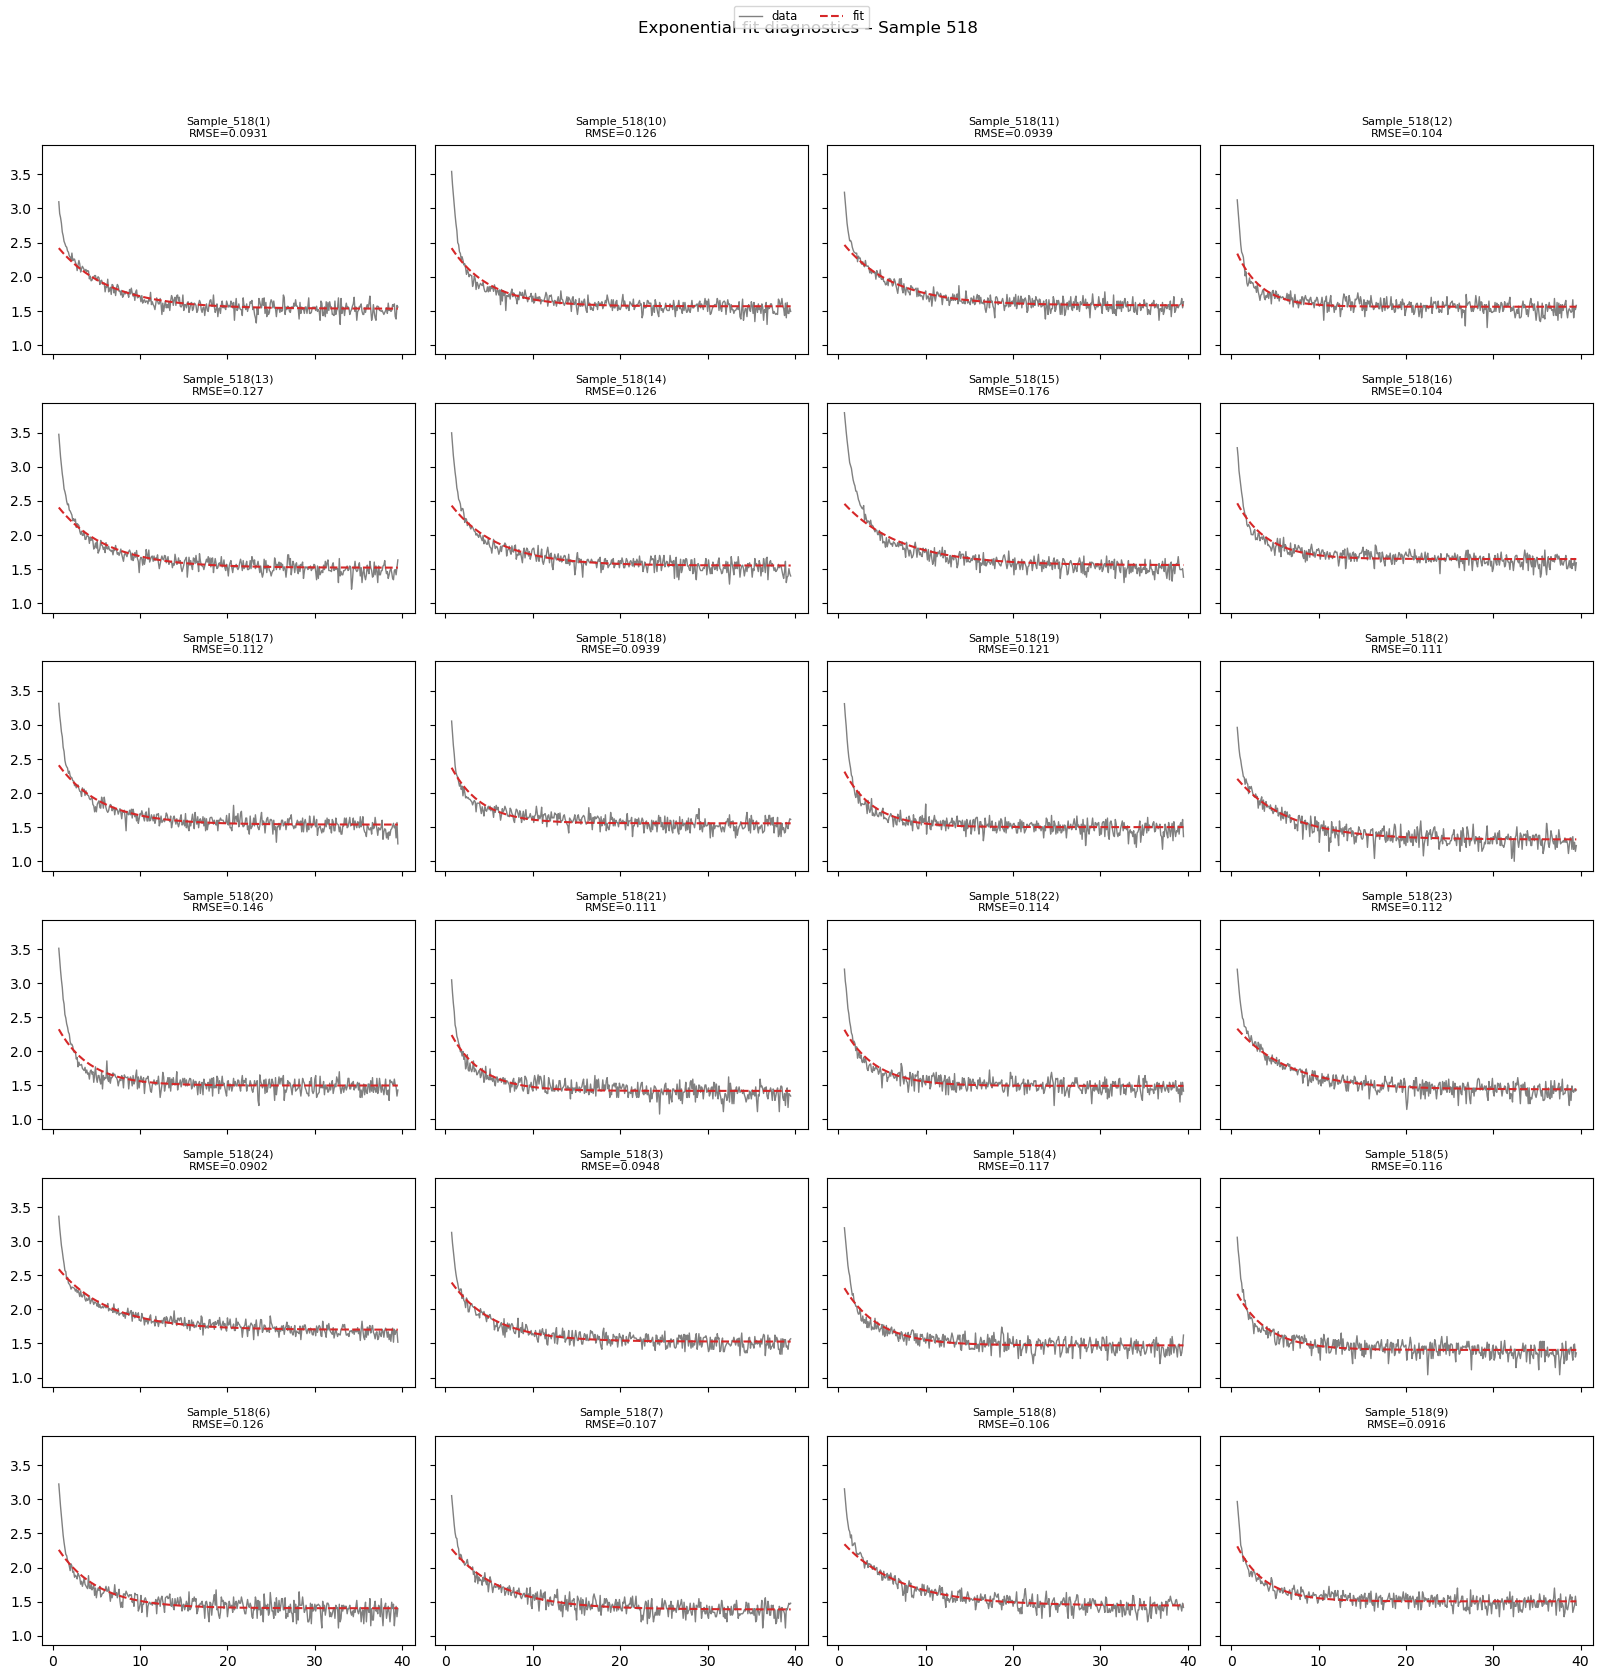

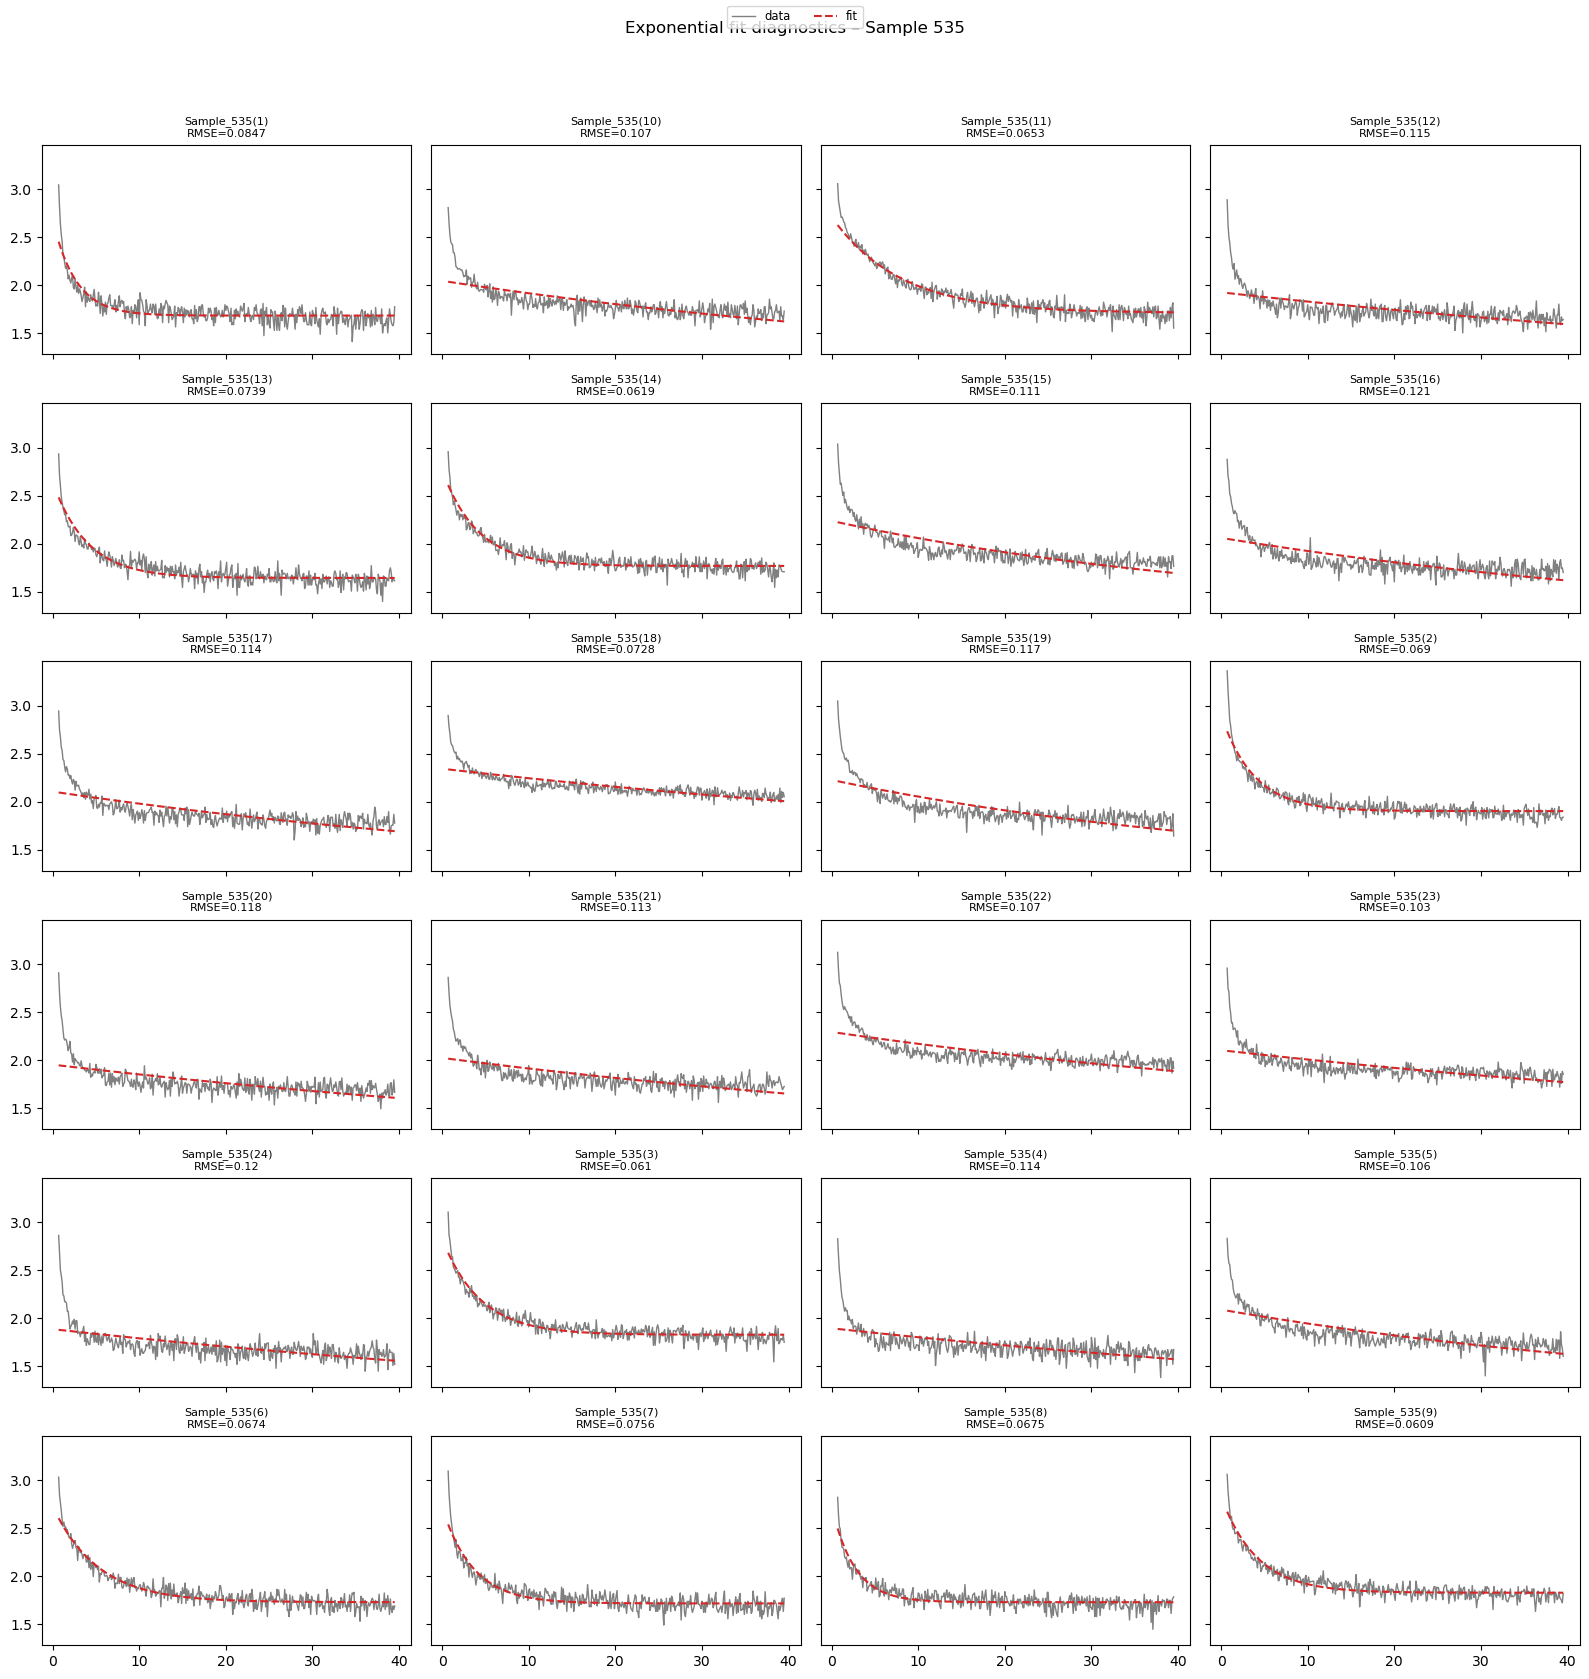

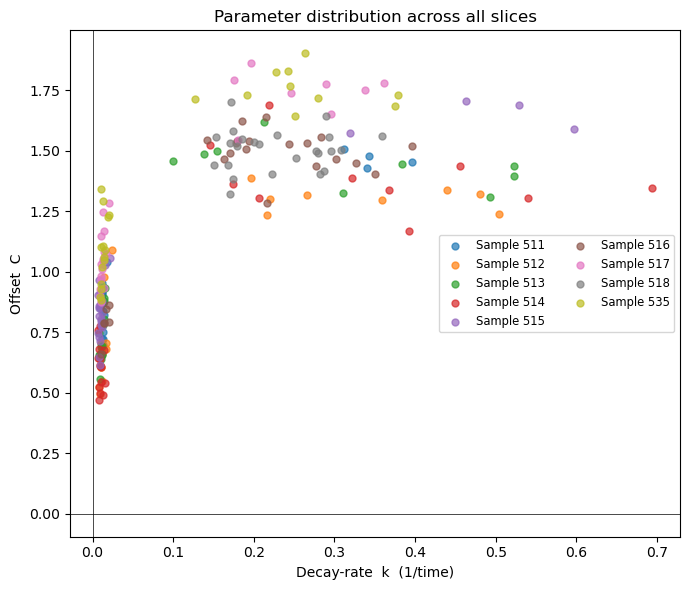

In [1]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------------------------------
# load data -----------------------------------------
# ---------------------------------------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found. Please check the path.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

def sample_matrix(sample_key):
    """Return time, X (n_slices × n_time), slice_names."""
    df = data_dict[sample_key]
    t  = df['Time'].astype(float).values
    cols = df.columns.difference(['Time', 'Time_index'])
    X  = df[cols].to_numpy(dtype=float).T
    return t, X, cols

# ---------------------------------------------------
# model & helper for a single slice -----------------
# ---------------------------------------------------
def exp_model(t, k, C):
    """Fixed unit amplitude exponential decay."""
    return C + np.exp(-k * t)

def fit_slice(t, y):
    """Return k, C, fitted_curve, RMSE."""
    # initial guesses: k=1/(max t), C = last value
    p0 = (1.0 / (t[-1] - t[0] + 1e-9), y[-1])
    (k, C), _ = curve_fit(exp_model, t, y, p0=p0, bounds=(0, np.inf))
    yhat = exp_model(t, k, C)
    rmse = np.sqrt(np.mean((y - yhat) ** 2))
    return k, C, yhat, rmse

# ---------------------------------------------------
# loop over all samples & slices --------------------
# ---------------------------------------------------
fit_records = []        # collect k, C, rmse for scatter
for sample in data_dict:
    t, Xs, slice_cols = sample_matrix(sample)
    n_slices = Xs.shape[0]

    # --- diagnostic figure per sample ---------------
    n_cols   = 4
    n_rows   = int(np.ceil(n_slices / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 2.8*n_rows),
                             sharex=True, sharey=True)
    axes = axes.ravel()

    for i, (y, name) in enumerate(zip(Xs, slice_cols)):
        k, C, yhat, rmse = fit_slice(t, y)
        fit_records.append({'sample': sample, 'slice': name,
                            'k': k, 'C': C, 'rmse': rmse})

        ax = axes[i]
        ax.plot(t, y,  lw=1, color='grey', label='data')
        ax.plot(t, yhat, ls='--', lw=1.5, color='tab:red', label='fit')
        ax.set_title(f'{name}\nRMSE={rmse:.3g}', fontsize=8)

    # hide any unused axes
    for ax in axes[n_slices:]:
        ax.axis('off')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize='small')
    fig.suptitle(f'Exponential fit diagnostics – Sample {sample}', y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------------------------------------------------
# scatter of parameter estimates --------------------
# ---------------------------------------------------
fit_df = pd.DataFrame(fit_records)

plt.figure(figsize=(7, 6))
for sample, grp in fit_df.groupby('sample'):
    plt.scatter(grp['k'], grp['C'], s=25, alpha=0.7, label=f'Sample {sample}')

plt.xlabel('Decay-rate  k  (1/time)')
plt.ylabel('Offset  C')
plt.title('Parameter distribution across all slices')
plt.axhline(0, lw=0.5, color='k')
plt.axvline(0, lw=0.5, color='k')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()
